# 1. Prior Knowledge

## 1.1 Vanilla RNN
Recurrent Neural Network(RNN)의 기본 수식은 다음과 같은 형태

$
h_t = \tanh(W_h x_t + U_h h_{t-1} + b_h)
$

- $x_t$: 입력 데이터 (시간 스텝 $t$에서)
- $h_t$: 히든 상태 (현재 시점의 기억을 저장하는 벡터)
- $W_h$, $U_h$, $b_h$: 학습 가능한 파라미터

이러한 수식으로 구현된 RNN은 긴 시퀀스를 학습할 때, 기울기가 지나치게 작아지거나 커지는 문제가 발생해,  
이를 해결하기 위해 LSTM과 GRU가 제안됨

## 1.2 LSTM(Long Short-Term Memory)
LSTM은 RNN의 장기 기억 능력을 개선하기 위해 개발되었으며,  
다음의 `4가지 gate를 통해 정볼르 선택적으로 유지하거나 제거`

- Forget gate ($f_t$): 잊어야 할 정보를 결정
- Input gate ($i_t$): 새로 추가할 정보를 결정
- Candidate memory cell ($\tilde{c}_t$): 새로 들어오는 정보를 저장하는 후보
- Output gate ($o_t$): 현재 히든 상태로 출력할 정보를 결정

이를 기반으로 하는 수식은 다음과 같음

$
\begin{aligned}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) \\[5pt]
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) \\[5pt]
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) \\[5pt]
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) \\[5pt]
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\[5pt]
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$


- $\sigma$ : sigmoid 함수
- $\odot$ : 요소별 곱셈(element-wise multiplication)

이를 기반으로 구현한 코드는 다음과 같음

In [ ]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        gates = self.linear_ih(x_t) + self.linear_hh(h_prev)

        i_t, f_t, g_t, o_t = torch.chunk(gates, 4, dim=1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)
        o_t = torch.sigmoid(o_t)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x, h0, c0):
        batch_size, seq_len, _ = x.size()
        h, c = h0, c0
        outputs = []

        for t in range(seq_len):
            h, c = self.cell(x[:, t, :], h, c)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), (h, c)

In [ ]:
torch.manual_seed(42)
device = torch.device('cpu') # 'cuda'로 적용할 경우, torch 내부의 fused kernel을 사용하여 결과값의 차이가 커질 수 있음

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)
c0 = torch.randn(batch_size, hidden_size).to(device)

my_lstm = LSTM(input_size, hidden_size).to(device)
torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

with torch.no_grad():
    torch_lstm.weight_ih_l0.copy_(my_lstm.cell.linear_ih.weight)
    torch_lstm.bias_ih_l0.copy_(my_lstm.cell.linear_ih.bias)
    torch_lstm.weight_hh_l0.copy_(my_lstm.cell.linear_hh.weight)
    torch_lstm.bias_hh_l0.copy_(my_lstm.cell.linear_hh.bias)

out_my, (h_n_my, c_n_my) = my_lstm(x, h0, c0)
out_torch, (h_n_torch, c_n_torch) = torch_lstm(x, (h0.unsqueeze(0), c0.unsqueeze(0)))

print("CPU LSTM Output 차이:", torch.abs(out_my - out_torch).max().item())
print("CPU LSTM hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())
print("CPU LSTM cell 차이:", torch.abs(c_n_my - c_n_torch.squeeze(0)).max().item())

CPU LSTM Output 차이: 5.960464477539063e-08
CPU LSTM hidden 차이: 2.9802322387695312e-08
CPU LSTM cell 차이: 1.1920928955078125e-07


In [ ]:
torch.manual_seed(42)
device = torch.device('cuda')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)
c0 = torch.randn(batch_size, hidden_size).to(device)

my_lstm = LSTM(input_size, hidden_size).to(device)
torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

with torch.no_grad():
    torch_lstm.weight_ih_l0.copy_(my_lstm.cell.linear_ih.weight)
    torch_lstm.bias_ih_l0.copy_(my_lstm.cell.linear_ih.bias)
    torch_lstm.weight_hh_l0.copy_(my_lstm.cell.linear_hh.weight)
    torch_lstm.bias_hh_l0.copy_(my_lstm.cell.linear_hh.bias)

out_my, (h_n_my, c_n_my) = my_lstm(x, h0, c0)
out_torch, (h_n_torch, c_n_torch) = torch_lstm(x, (h0.unsqueeze(0), c0.unsqueeze(0)))

print("GPU LSTM Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GPU LSTM hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())
print("GPU LSTM cell 차이:", torch.abs(c_n_my - c_n_torch.squeeze(0)).max().item())

CPU LSTM Output 차이: 7.858872413635254e-05
CPU LSTM hidden 차이: 7.539987564086914e-05
CPU LSTM cell 차이: 0.00010293722152709961


## 1.3 GRU(Gated Recurrent Unit)
GRU는 LSTM보다 구조가 간단하면서도 유사한 성능을 내며, 다음과 같은 두 개의 gate로 구성

- Update gate ($z_t$): 이전 상태를 얼마나 유지할지 결정
- Reset gate ($r_t$): 이전 상태를 얼마나 잊을지 결정

이를 이용한 수식은 다음과 같음

$
\begin{aligned}
z_t &= \sigma(W_z [x_t, h_{t-1}] + b_z) \\[5pt]
r_t &= \sigma(W_r [x_t, h_{t-1}] + b_r) \\[5pt]
\tilde{h}_t &= \tanh(W_h [x_t, r_t \odot h_{t-1}] + b_h) \\[5pt]
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$


위 수식에서,
- $x_t$: 시간 단계 $t$의 입력 벡터
- $h_t$: 시간 단계 $t$의 hidden state 벡터
- $z_t$: update gate (과거 정보를 유지할지 결정)
- $r_t$: reset gate (과거 정보를 잊을지 결정)
- $\sigma$: sigmoid 활성화 함수
- $\odot$: element-wise 곱셈 연산
- $W$, $U$: 학습 가능한 가중치
- $b$: 편향(bias)

이를 이용해 코드로 구현하면 다음과 같음

In [5]:
import torch
import torch.nn as nn

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 입력 → 게이트 연산
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))

        # 히든 → 게이트 연산
        self.weight_hh = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(3 * hidden_size))

    def forward(self, x_t, h_prev):
        gi = torch.nn.functional.linear(x_t, self.weight_ih, self.bias_ih)
        gh = torch.nn.functional.linear(h_prev, self.weight_hh, self.bias_hh)

        i_r, i_z, i_n = gi.chunk(3, dim=1)
        h_r, h_z, h_n = gh.chunk(3, dim=1)

        r_t = torch.sigmoid(i_r + h_r)
        z_t = torch.sigmoid(i_z + h_z)

        # reset gate는 bias를 곱하지 않도록 연산 순서를 명확히 
        n_t = torch.tanh(i_n + r_t * (torch.nn.functional.linear(h_prev, 
                                   self.weight_hh[2*self.hidden_size:], 
                                   self.bias_hh[2*self.hidden_size:])))

        h_t = (1 - z_t) * n_t + z_t * h_prev

        return h_t

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.cell = GRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        batch_size, seq_len, _ = x.size()
        h = h0
        outputs = []

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs, h

In [7]:
torch.manual_seed(42)
device = torch.device('cpu')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)

my_gru = GRU(input_size, hidden_size).to(device)
torch_gru = nn.GRU(input_size, hidden_size, batch_first=True).to(device)

# 가중치 복사
with torch.no_grad():
    torch_gru.weight_ih_l0.copy_(my_gru.cell.weight_ih)
    torch_gru.bias_ih_l0.copy_(my_gru.cell.bias_ih)
    torch_gru.weight_hh_l0.copy_(my_gru.cell.weight_hh)
    torch_gru.bias_hh_l0.copy_(my_gru.cell.bias_hh)

out_my, h_n_my = my_gru(x, h0)
out_torch, h_n_torch = torch_gru(x, h0.unsqueeze(0))

print("GRU 전체 Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GRU 마지막 hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())

GRU 전체 Output 차이: 1.4901161193847656e-07
GRU 마지막 hidden 차이: 1.4901161193847656e-07


In [8]:
torch.manual_seed(42)
device = torch.device('cuda')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)

my_gru = GRU(input_size, hidden_size).to(device)
torch_gru = nn.GRU(input_size, hidden_size, batch_first=True).to(device)

# 가중치 복사
with torch.no_grad():
    torch_gru.weight_ih_l0.copy_(my_gru.cell.weight_ih)
    torch_gru.bias_ih_l0.copy_(my_gru.cell.bias_ih)
    torch_gru.weight_hh_l0.copy_(my_gru.cell.weight_hh)
    torch_gru.bias_hh_l0.copy_(my_gru.cell.bias_hh)

out_my, h_n_my = my_gru(x, h0)
out_torch, h_n_torch = torch_gru(x, h0.unsqueeze(0))

print("GRU 전체 Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GRU 마지막 hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())

GRU 전체 Output 차이: 0.0007819235324859619
GRU 마지막 hidden 차이: 0.0006472766399383545


# 2. Minimalize GRU

## 2.1 이전 상태 $h_{t-1}$ 의존 제거

Minimalization을 위한 첫 번째 단계는 Mamba에서 적용된 방식과 같이 병렬 처리를 가능하도록 함으로써 하드웨어 자원을 최대한 활용해 연산 효율성을 높이는 것으로, 이전 상태($h_{t-1}$)을 제거

### 기존 구조
- $z_t$, $r_t$, $\tilde{h}_t$ 모두 $h_{t-1}$에 의존 → 병렬화 불가능

### 변경 구조
- $z_t = \sigma(W_z x_t)$
- $r_t = \text{(삭제)}$
- $\tilde{h}_t = W_h x_t$

## 2.2 비선형 함수 $\tanh$ 제거

$\tanh$는 출력값을 $(-1, 1)$로 제한하는 활성화 함수로,  
이를 제거하면 표현력은 약간 줄지만, 선형 처리 및 병렬화가 더 쉬워짐

(왜????)

$
\tilde{h}_t = W_h x_t \quad (\text{선형 처리})
$

## 2.3 최종 minGRU 구조 도출

현재까지의 최종적인 수식은 다음과 같음

$
\begin{aligned}
z_t &= \sigma(W_z x_t) \\
\tilde{h}_t &= W_h x_t \\
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$

위 구조는 다음과 같은 장점을 지니고 있음
- 파라미터 수가 **3개 → 2개**로 줄어들고, 연산량도 줄어듦
- 단일 입력만으로 상태 갱신 가능 → 병렬화 가능성 확보

## 2.4 minGRU를 병렬 구조로 해석하기 (Prefix-Scan 구조)

위까지의 수식을 아래와 같이 단순화

$
h_t = a_t \odot h_{t-1} + b_t \quad \\ 
\text{where} \quad a_t = 1 - z_t,\quad b_t = z_t \odot \tilde{h}_t
$

위 수식은 정확히 **선형 recurrence 형태**이며, 아래와 같은 누적 합 형태의 scan 구조로 근사 가능

$
h_t = \sum_{k=0}^{t} \left( b_k \prod_{j=k+1}^{t} a_j \right)
$


위 구조는 병렬 Blelloch scan과 같은 scan 알고리즘을 통해 $\mathcal{O}(\log T)$ 병렬 처리가 가능

### minGRU의 전체 수식

$
\begin{aligned}
z_t &= \sigma(W_z x_t) \\[4pt]
\tilde{h}_t &= W_h x_t \\[4pt]
a_t &= 1 - z_t \\[4pt]
b_t &= z_t \odot \tilde{h}_t \\[4pt]
h_t &= a_t \odot h_{t-1} + b_t
\end{aligned}
$

## 2.5 코드

### 2.5.1 Overal Structure(Simple)

In [9]:
import torch
import torch.nn as nn

class MinGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size, bias=True)
        self.h_proj = nn.Linear(input_size, hidden_size, bias=True)
        self.hidden_size = hidden_size

    def forward(self, x_t, h_prev):
        z_t = torch.sigmoid(self.z_proj(x_t))              # update gate
        h_tilde = self.h_proj(x_t)                         # candidate hidden
        a_t = 1.0 - z_t
        b_t = z_t * h_tilde
        h_t = a_t * h_prev + b_t
        return h_t


In [10]:
class MinGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = MinGRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        # x: [B, T, input_size]
        batch_size, seq_len, _ = x.size()
        h = h0
        outputs = []

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), h


In [11]:
# 실험 설정
input_size = 3
hidden_size = 5
batch_size = 2
seq_len = 4

torch.manual_seed(0)

# 입력 데이터 생성
x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.zeros(batch_size, hidden_size)

# minGRU 모델 실행
min_gru = MinGRU(input_size, hidden_size)
out_seq, h_last = min_gru(x, h0)

print("입력 시퀀스 크기:", x.shape)
print("출력 시퀀스 크기:", out_seq.shape)
print("최종 hidden 상태:", h_last.shape)
print("출력 예시:", out_seq[0])


입력 시퀀스 크기: torch.Size([2, 4, 3])
출력 시퀀스 크기: torch.Size([2, 4, 5])
최종 hidden 상태: torch.Size([2, 5])
출력 예시: tensor([[ 0.0162, -0.3345, -0.1807, -0.0015, -0.4170],
        [ 0.1418, -0.0706, -0.1691, -0.4127, -0.0728],
        [-0.0705, -0.4927, -0.2593, -0.0867, -0.5415],
        [ 0.1813, -0.1056, -0.2391, -0.4562, -0.0858]],
       grad_fn=<SelectBackward0>)


### 2.5.2 prefix-scan (not parallel yet, just logic)

Mamba에서와 동일하게 torch로는 병렬 스캔이 어려워,  
일단 순차적인 방식으로 구현해 수치적인 차이가 없는지 확인

In [12]:
def prefix_scan_min_gru(a_seq, b_seq, h0):
    """
    시뮬레이션용 prefix-scan 방식의 minGRU
    - a_seq: [B, T, H], 곱해지는 계수 (1 - z)
    - b_seq: [B, T, H], 가중합 (z * h_tilde)
    - h0:    [B, H], 초기 hidden
    """
    B, T, H = a_seq.shape
    h = h0
    outputs = []

    for t in range(T):
        h = a_seq[:, t] * h + b_seq[:, t]
        outputs.append(h.unsqueeze(1))

    return torch.cat(outputs, dim=1)

### 2.5.3 ADD prefix-scan TO minGRU

In [13]:
class MinGRU_w_SCAN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size)
        self.h_proj = nn.Linear(input_size, hidden_size)

    def forward(self, x, h0):
        # x: [B, T, input_size]
        z = torch.sigmoid(self.z_proj(x))            # [B,T,H]
        h_tilde = self.h_proj(x)                     # [B,T,H]
        a = 1 - z
        b = z * h_tilde
        return prefix_scan_min_gru(a, b, h0)


### 2.5.4 Test

In [14]:
input_size = 3
hidden_size = 5
batch_size = 2
seq_len = 6

x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.zeros(batch_size, hidden_size)

# 순차 구현
min_gru_seq = MinGRU(input_size, hidden_size)
out_seq, _ = min_gru_seq(x, h0)

# 병렬 구현
min_gru_par = MinGRU_w_SCAN(input_size, hidden_size)

# 동일 weight 복사
min_gru_par.z_proj.load_state_dict(min_gru_seq.cell.z_proj.state_dict())
min_gru_par.h_proj.load_state_dict(min_gru_seq.cell.h_proj.state_dict())
out_par = min_gru_par(x, h0)

# 비교
max_diff = torch.abs(out_seq - out_par).max().item()
print(f"순차 vs 병렬 minGRU 출력 차이: {max_diff:.6f}")

순차 vs 병렬 minGRU 출력 차이: 0.000000


## 3. Performance Test (Single Layer & Simple Structure)

## 3.1 Construct Small Dataset

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 데이터 로드 및 정규화
data = load_wine()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)  # 표준화
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, 13, 1)
y = torch.tensor(y, dtype=torch.long)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)


## 3.2 GRU Classifier (Manual)

In [16]:
class ManualGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.fc.in_features, device=x.device)
        h_seq, _ = self.gru(x, h0)
        return self.fc(h_seq[:, -1])


## 3.3 GRU Classifier(Torch Official)

In [17]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

## 3.4 minGRU Classifier (not parallel yet)

In [18]:
class MinGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = MinGRU_w_SCAN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.gru.h_proj.out_features, device=x.device)
        h_seq = self.gru(x, h0)
        return self.fc(h_seq[:, -1])


## 3.5 Train & Validation

In [19]:
import time

def train_and_eval(model, train_loader, test_loader, epochs=50, lr=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    hist = {"train_acc": [], "test_acc": [], "train_loss": [], "test_loss": []}

    for ep in range(epochs):
        t0 = time.time()
        model.train()
        correct = total = 0
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
        hist["train_acc"].append(correct / total)
        hist["train_loss"].append(total_loss / total)

        model.eval()
        correct = total = 0
        total_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = crit(pred, yb)
                total_loss += loss.item() * xb.size(0)
                correct += (pred.argmax(1) == yb).sum().item()
                total += yb.size(0)
        hist["test_acc"].append(correct / total)
        hist["test_loss"].append(total_loss / total)

        print(f"[Epoch {ep+1:02d}] Train Acc: {hist['train_acc'][-1]*100:.2f}% | "
              f"Test Acc: {hist['test_acc'][-1]*100:.2f}% | Time: {time.time()-t0:.2f}s")

    return hist

In [20]:
def plot_history(histories):
    plt.figure(figsize=(10,6))
    for name, h in histories.items():
        plt.plot(h["train_acc"], linestyle="-", label=f"{name} Train Acc")
        plt.plot(h["test_acc"], linestyle="--", label=f"{name} Test Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Train / Test Accuracy per Epoch")
    plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    for name, h in histories.items():
        plt.plot(h["train_loss"], linestyle="-", label=f"{name} Train Loss")
        plt.plot(h["test_loss"], linestyle="--", label=f"{name} Test Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Train / Test Loss per Epoch")
    plt.legend(); plt.grid(True)
    plt.show()

In [21]:
def print_model_structure(model, name):
    print(f"\n>>> {name} 모델 구조:")
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters())}")
    print(f"모델 구조: {model}")


>>> MyGRU 모델 구조:
모델 파라미터 수: 291
모델 구조: ManualGRUClassifier(
  (gru): GRU(
    (cell): GRUCell()
  )
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

>>> MyGRU 학습 시작
[Epoch 01] Train Acc: 46.48% | Test Acc: 80.56% | Time: 0.27s
[Epoch 02] Train Acc: 89.44% | Test Acc: 97.22% | Time: 0.16s
[Epoch 03] Train Acc: 91.55% | Test Acc: 97.22% | Time: 0.16s

>>> GRU 모델 구조:
모델 파라미터 수: 291
모델 구조: GRUClassifier(
  (gru): GRU(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

>>> GRU 학습 시작
[Epoch 01] Train Acc: 51.41% | Test Acc: 72.22% | Time: 0.17s
[Epoch 02] Train Acc: 69.72% | Test Acc: 72.22% | Time: 0.02s
[Epoch 03] Train Acc: 69.01% | Test Acc: 86.11% | Time: 0.02s

>>> minGRU 모델 구조:
모델 파라미터 수: 227
모델 구조: MinGRUClassifier(
  (gru): MinGRU_w_SCAN(
    (z_proj): Linear(in_features=1, out_features=32, bias=True)
    (h_proj): Linear(in_features=1, out_features=32, bias=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

>>> minGRU 

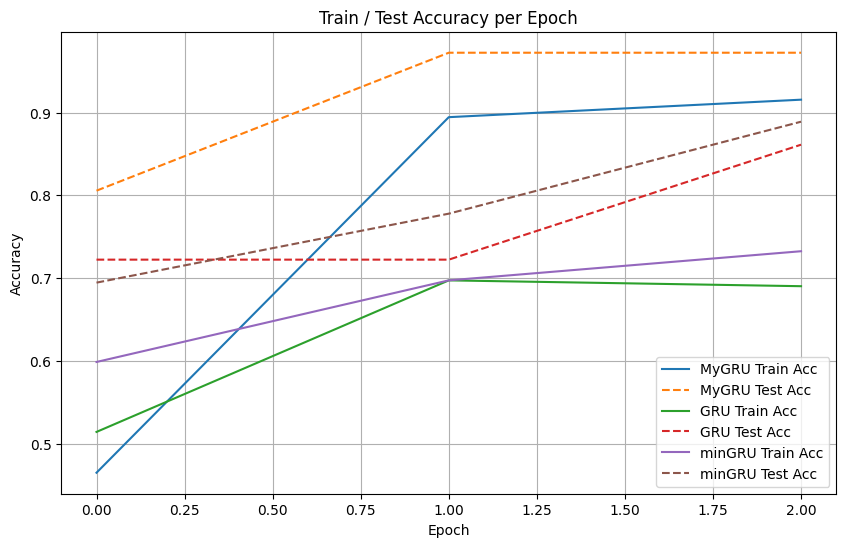

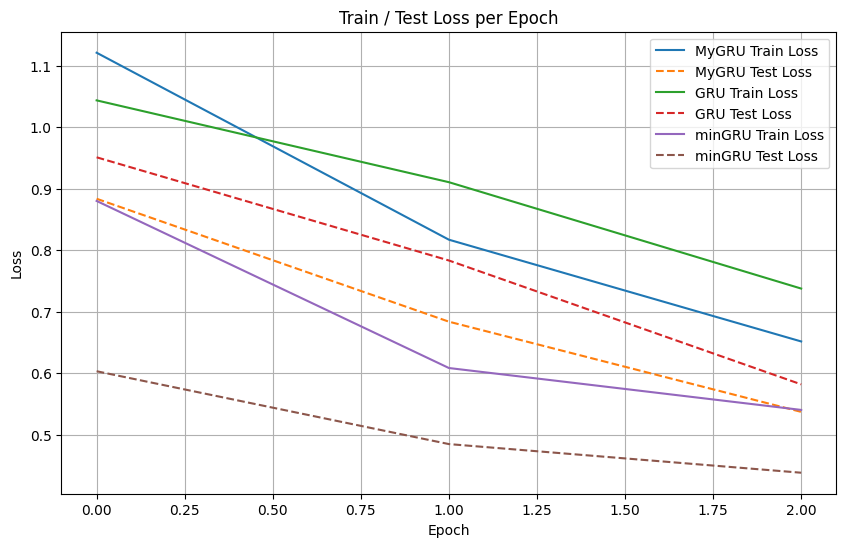

In [22]:
# 정의
input_size = 1
hidden_size1 = 8
hidden_size2 = 32
num_classes = 3

models = {
    "MyGRU": ManualGRUClassifier(input_size, hidden_size1, num_classes),
    "GRU": GRUClassifier(input_size, hidden_size1, num_classes),
    "minGRU": MinGRUClassifier(input_size, hidden_size2, num_classes),
}

histories = {}

# 실행
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    hist = train_and_eval(model, train_loader, test_loader, epochs=3)
    histories[name] = hist

# 시각화
plot_history(histories)


# 4. Minimalize LSTM

Minimalize하는 과정(원리)는 GRU와 같으며, 이전에 살펴봤던 LSTM의 최종 수식은 다음과 같았음

$
\begin{aligned}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) \\[4pt]
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) \\[4pt]
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) \\[4pt]
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) \\[4pt]
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\[4pt]
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$

## 4.1 $h_{t-1}$ 의존성 제거

병렬화를 위해 이전 상태에 대한 의존성을 제거함으로써 현재의 입력 $x_{t}$에만 의존하도록 변경

$
\begin{aligned}
f_t &= \sigma(W_f x_t), \\
i_t &= \sigma(W_i x_t), \\
\tilde{c}_t &= \tanh(W_c x_t), \\
o_t &= \sigma(W_o x_t)
\end{aligned}
$

*단, 이후 minLSTM에서는 $o_t$ 게이트도 제거됩니다.


## 4.2 $\tanh$ 제거

$\tilde{c}_t$에 적용되던 비선형 함수 $\tanh$를 제거해, 약간의 표현력 감소를 감수하고 선형 처리 및 병렬화에 용이하도록 변경

$
\tilde{c}_t = W_c x_t \quad (\text{선형})
$

## 4.3 게이트 정규화 - Softmax-like

$f_t$와 $i_t$는 softmax처럼 정규화된 가중치로 해석되며 다음과 같이 변경

$
f'_t = \frac{f_t}{f_t + i_t}, \quad
i'_t = \frac{i_t}{f_t + i_t}
$

위 수식을 고려해 최종적으로 다음과 같이 간소화할 수 있음

$
\begin{aligned}
f_t &= \sigma(W_f x_t), \\
i_t &= \sigma(W_i x_t), \\
\tilde{c}_t &= W_c x_t, \\
f'_t &= \frac{f_t}{f_t + i_t}, \\
i'_t &= \frac{i_t}{f_t + i_t}, \\
h_t &= f'_t \odot h_{t-1} + i'_t \odot \tilde{c}_t
\end{aligned}
$

## 4.4 코드 구현

In [23]:
class MinLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.f_proj = nn.Linear(input_size, hidden_size)
        self.i_proj = nn.Linear(input_size, hidden_size)
        self.c_proj = nn.Linear(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x_t, h_prev):
        f_t = torch.sigmoid(self.f_proj(x_t))
        i_t = torch.sigmoid(self.i_proj(x_t))
        denom = f_t + i_t + 1e-6 # 작은 값 추가
        f_hat = f_t / denom
        i_hat = i_t / denom
        c_tilde = self.c_proj(x_t)
        h_t = f_hat * h_prev + i_hat * c_tilde
        return h_t

In [24]:
class MinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = MinLSTMCell(input_size, hidden_size)

    def forward(self, x, h0):
        h = h0
        outputs = []
        for t in range(x.size(1)):
            h = self.cell(x[:, t], h)
            outputs.append(h.unsqueeze(1))
        return torch.cat(outputs, dim=1), h

## 4.5 Performance Test

### 4.5.1 Manual LSTM Classifier

In [25]:
class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B = x.size(0)
        h0 = torch.zeros(B, self.fc.in_features, device=x.device)
        c0 = torch.zeros(B, self.fc.in_features, device=x.device)
        h_seq, _ = self.rnn(x, h0, c0)
        return self.fc(h_seq[:, -1])

### 4.5.2 Official LSTM Classifier

In [26]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


### 4.5.3 minLSTM Classifier

In [27]:
class MinLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = MinLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.fc.in_features, device=x.device)
        h_seq, _ = self.rnn(x, h0)
        return self.fc(h_seq[:, -1])


>>> ManualLSTM 모델 구조:
모델 파라미터 수: 379
모델 구조: ManualLSTMClassifier(
  (rnn): LSTM(
    (cell): LSTMCell(
      (linear_ih): Linear(in_features=1, out_features=32, bias=True)
      (linear_hh): Linear(in_features=8, out_features=32, bias=True)
    )
  )
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

>>> ManualLSTM 학습 시작
[Epoch 01] Train Acc: 40.14% | Test Acc: 44.44% | Time: 0.12s
[Epoch 02] Train Acc: 47.89% | Test Acc: 66.67% | Time: 0.12s
[Epoch 03] Train Acc: 66.20% | Test Acc: 77.78% | Time: 0.12s

>>> LSTM 모델 구조:
모델 파라미터 수: 379
모델 구조: LSTMClassifier(
  (lstm): LSTM(1, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

>>> LSTM 학습 시작
[Epoch 01] Train Acc: 40.14% | Test Acc: 38.89% | Time: 0.02s
[Epoch 02] Train Acc: 56.34% | Test Acc: 69.44% | Time: 0.02s
[Epoch 03] Train Acc: 66.20% | Test Acc: 69.44% | Time: 0.02s

>>> minLSTM 모델 구조:
모델 파라미터 수: 291
모델 구조: MinLSTMClassifier(
  (rnn): MinLSTM(
    (cell): MinLSTMCell(
      (f_proj): Linear

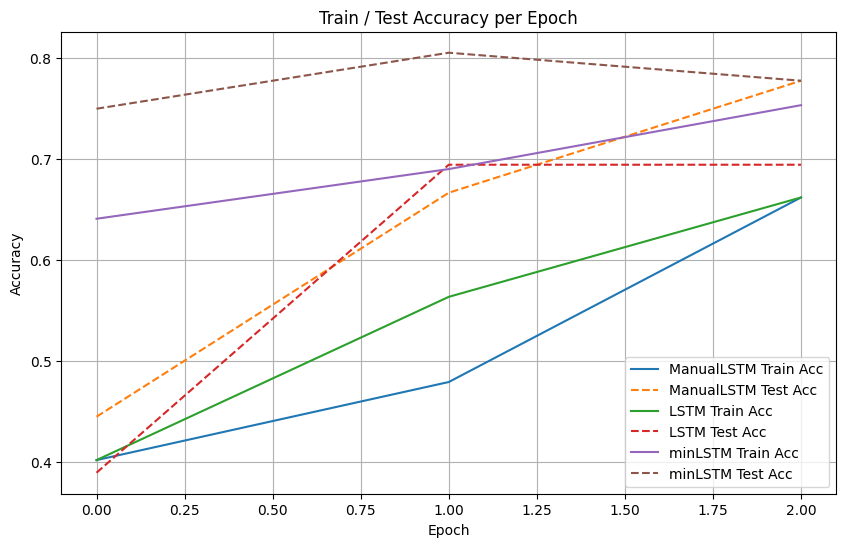

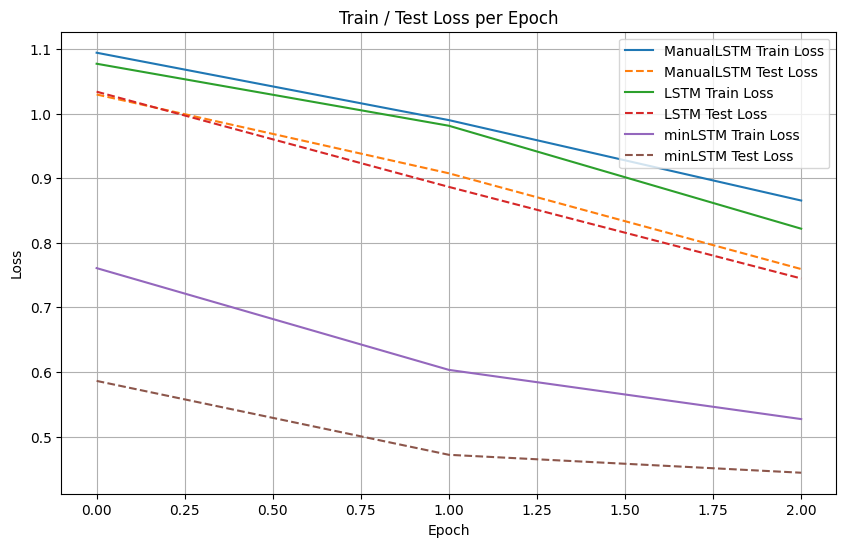

In [29]:
# 모델 초기화
input_size = 1
hidden_size1 = 8
hidden_size2 = 32
num_classes = 3

models = {
    "ManualLSTM": ManualLSTMClassifier(input_size, hidden_size1, num_classes),
    "LSTM": LSTMClassifier(input_size, hidden_size1, num_classes),
    "minLSTM": MinLSTMClassifier(input_size, hidden_size2, num_classes),
}

# 학습 기록 저장
histories = {}
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    hist = train_and_eval(model, train_loader, test_loader, epochs=3)
    histories[name] = hist
# 시각화
plot_history(histories)

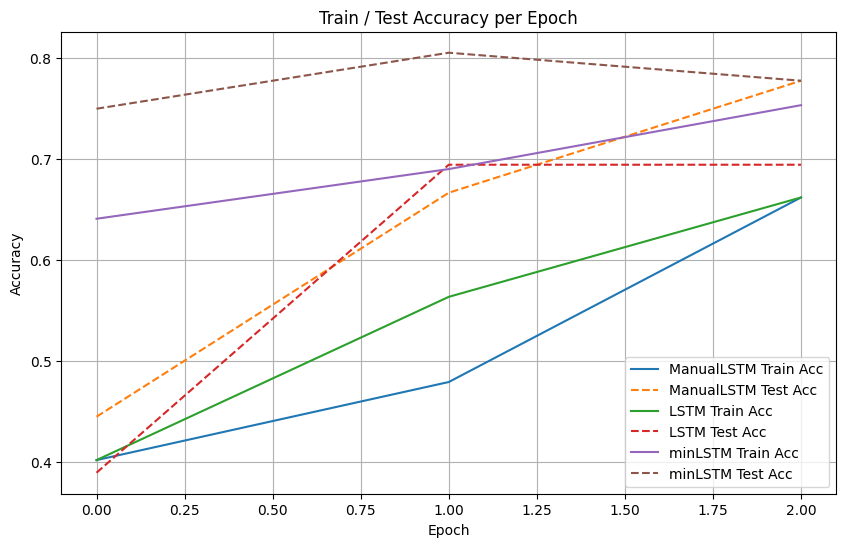

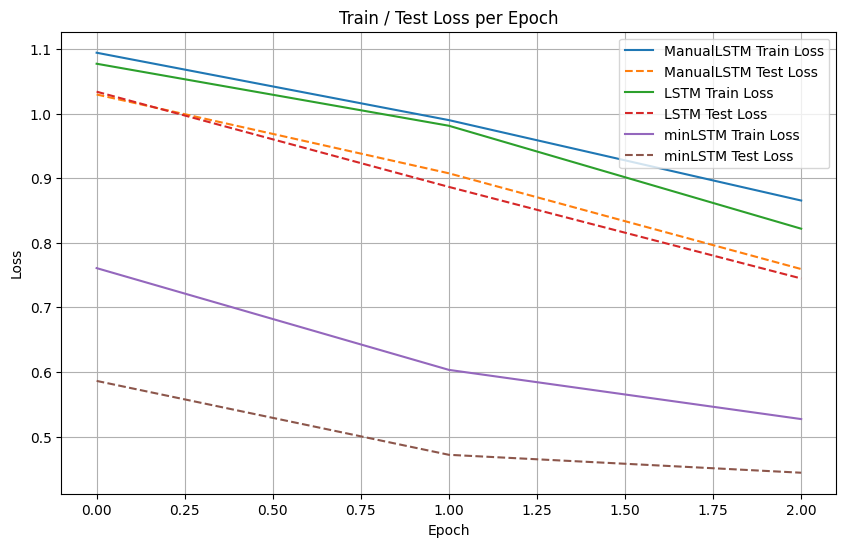

In [30]:
# 시각화
plot_history(histories)

# 5. Multi Layer & Complicate Structure

## 5.1 RNN Block

### Block for GRU, minGRU

In [31]:
class RNNBlockGRU(nn.Module):
    def __init__(self, cell_class, input_size, hidden_size, num_layers=4, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList() if norm else None
        self.dropouts = nn.ModuleList()

        for i in range(num_layers):
            in_dim = input_size if i == 0 else hidden_size
            self.layers.append(cell_class(in_dim, hidden_size))
            if norm:
                self.norms.append(nn.LayerNorm(hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

    def forward(self, x, h0=None):
        B, T, _ = x.shape
        for i, layer in enumerate(self.layers):
            out_seq = []
            h = h0[i] if h0 is not None else x.new_zeros(B, layer.hidden_size)
            for t in range(T):
                h = layer(x[:, t], h)
                out_seq.append(h.unsqueeze(1))
            x_ = torch.cat(out_seq, dim=1)

            if self.norms: x_ = self.norms[i](x_)
            x_ = self.dropouts[i](x_)
            if self.residual and x_.shape == x.shape:
                x_ = x + x_
            x = x_
        return x

### Block for LSTM

In [32]:
class RNNBlockLSTM(nn.Module):
    def __init__(self, cell_class, input_size, hidden_size, num_layers=4, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList() if norm else None
        self.dropouts = nn.ModuleList()

        for i in range(num_layers):
            in_dim = input_size if i == 0 else hidden_size
            self.layers.append(cell_class(in_dim, hidden_size))
            if norm:
                self.norms.append(nn.LayerNorm(hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

    def forward(self, x, h0=None, c0=None):
        B, T, _ = x.shape
        hs, cs = [], []
        for i, layer in enumerate(self.layers):
            out_seq = []
            h = h0[i] if h0 is not None else x.new_zeros(B, layer.hidden_size)
            c = c0[i] if c0 is not None else x.new_zeros(B, layer.hidden_size)
            for t in range(T):
                h, c = layer(x[:, t], h, c)
                out_seq.append(h.unsqueeze(1))
            x_ = torch.cat(out_seq, dim=1)

            if self.norms: x_ = self.norms[i](x_)
            x_ = self.dropouts[i](x_)
            if self.residual and x_.shape == x.shape:
                x_ = x + x_
            x = x_
            hs.append(h)
            cs.append(c)
        return x, (torch.stack(hs), torch.stack(cs))


### Block for minLSTM

In [33]:
class MinLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=4, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList() if norm else None
        self.dropouts = nn.ModuleList()

        for i in range(num_layers):
            in_dim = input_size if i == 0 else hidden_size
            self.layers.append(MinLSTMCell(in_dim, hidden_size))
            if norm:
                self.norms.append(nn.LayerNorm(hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

    def forward(self, x, h0=None):
        B, T, _ = x.shape
        hs = []
        for i, layer in enumerate(self.layers):
            out_seq = []
            h = h0[i] if h0 is not None else x.new_zeros(B, layer.hidden_size)
            for t in range(T):
                h = layer(x[:, t], h)
                out_seq.append(h.unsqueeze(1))
            x_ = torch.cat(out_seq, dim=1)

            if self.norms: x_ = self.norms[i](x_)
            x_ = self.dropouts[i](x_)
            if self.residual and x_.shape == x.shape:
                x_ = x + x_
            x = x_
            hs.append(h)
        return x, torch.stack(hs)


## 5.2 Define Models

### 5.2.1 Manual GRU

In [34]:
class ModernManualGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNNBlockGRU(GRUCell, input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        x = self.rnn(x)
        return self.fc(x[:, -1])

### 5.2.2 Manual LSTM

In [35]:
class ModernManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNNBlockLSTM(LSTMCell, input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros((self.rnn.num_layers, B, self.fc.in_features))
        c0 = x.new_zeros((self.rnn.num_layers, B, self.fc.in_features))
        x, _ = self.rnn(x, h0, c0)
        return self.fc(x[:, -1])


### 5.2.3 minGRU

In [36]:
class ModernMinGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNNBlockGRU(MinGRUCell, input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.rnn(x)
        return self.fc(x[:, -1])

### 5.2.4 minLSTM

In [37]:
class ModernMinLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = MinLSTMBlock(input_size, hidden_size, num_layers=4)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.rnn(x)
        return self.fc(x[:, -1])

## 5.3 Train & Validation

In [38]:
models = {
    "ManualGRU": ModernManualGRUClassifier(1, 32, 3),
    "MinGRU": ModernMinGRUClassifier(1, 32, 3),
}

In [39]:
histories = {}
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    histories[name] = train_and_eval(model, train_loader, test_loader, epochs=3)



>>> ManualGRU 모델 구조:
모델 파라미터 수: 22723
모델 구조: ModernManualGRUClassifier(
  (rnn): RNNBlockGRU(
    (layers): ModuleList(
      (0-3): 4 x GRUCell()
    )
    (norms): ModuleList(
      (0-3): 4 x LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (dropouts): ModuleList(
      (0-3): 4 x Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

>>> ManualGRU 학습 시작
[Epoch 01] Train Acc: 47.89% | Test Acc: 63.89% | Time: 0.61s
[Epoch 02] Train Acc: 63.38% | Test Acc: 69.44% | Time: 0.54s
[Epoch 03] Train Acc: 71.13% | Test Acc: 52.78% | Time: 0.54s

>>> MinGRU 모델 구조:
모델 파라미터 수: 6819
모델 구조: ModernMinGRUClassifier(
  (rnn): RNNBlockGRU(
    (layers): ModuleList(
      (0): MinGRUCell(
        (z_proj): Linear(in_features=1, out_features=32, bias=True)
        (h_proj): Linear(in_features=1, out_features=32, bias=True)
      )
      (1-3): 3 x MinGRUCell(
        (z_proj): Linear(in_features=32, out_features=32, bias=True)
        (h_pro

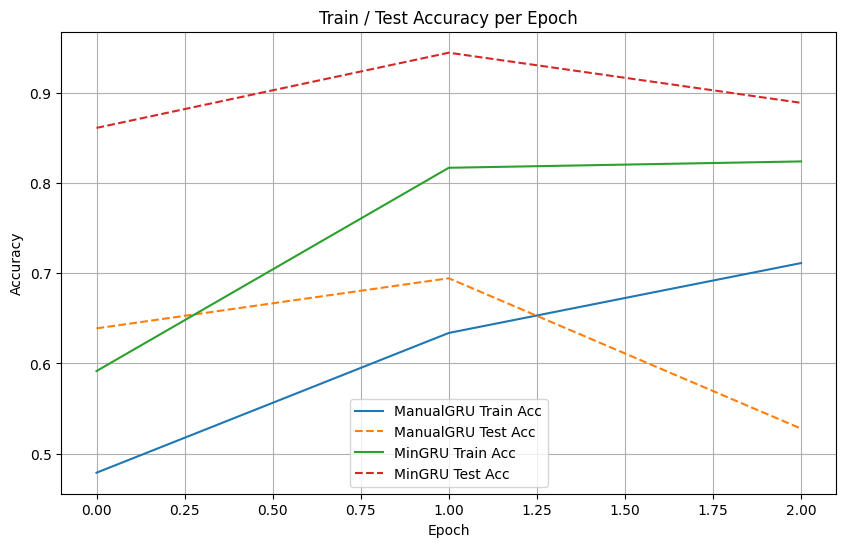

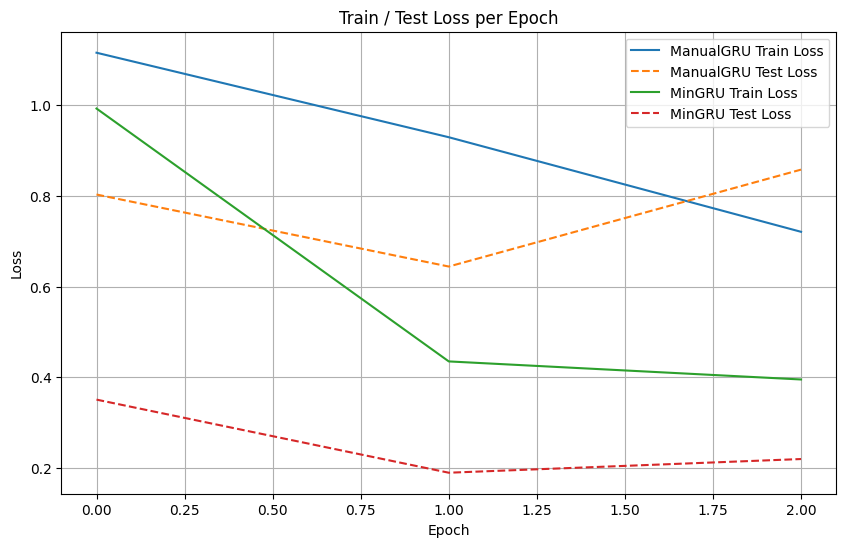

In [40]:
plot_history(histories)

In [41]:
models = {
    "ManualLSTM": ModernManualLSTMClassifier(1, 32, 3),
    "MinLSTM": ModernMinLSTMClassifier(1, 32, 3)
}

In [42]:
histories = {}
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    histories[name] = train_and_eval(model, train_loader, test_loader, epochs=3)



>>> ManualLSTM 모델 구조:
모델 파라미터 수: 30179
모델 구조: ModernManualLSTMClassifier(
  (rnn): RNNBlockLSTM(
    (layers): ModuleList(
      (0): LSTMCell(
        (linear_ih): Linear(in_features=1, out_features=128, bias=True)
        (linear_hh): Linear(in_features=32, out_features=128, bias=True)
      )
      (1-3): 3 x LSTMCell(
        (linear_ih): Linear(in_features=32, out_features=128, bias=True)
        (linear_hh): Linear(in_features=32, out_features=128, bias=True)
      )
    )
    (norms): ModuleList(
      (0-3): 4 x LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (dropouts): ModuleList(
      (0-3): 4 x Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

>>> ManualLSTM 학습 시작
[Epoch 01] Train Acc: 61.97% | Test Acc: 94.44% | Time: 0.44s
[Epoch 02] Train Acc: 88.73% | Test Acc: 97.22% | Time: 0.46s
[Epoch 03] Train Acc: 90.14% | Test Acc: 97.22% | Time: 0.46s

>>> MinLSTM 모델 구조:
모델 파라미터 수: 10051
모델 구조: ModernMinLSTMClas

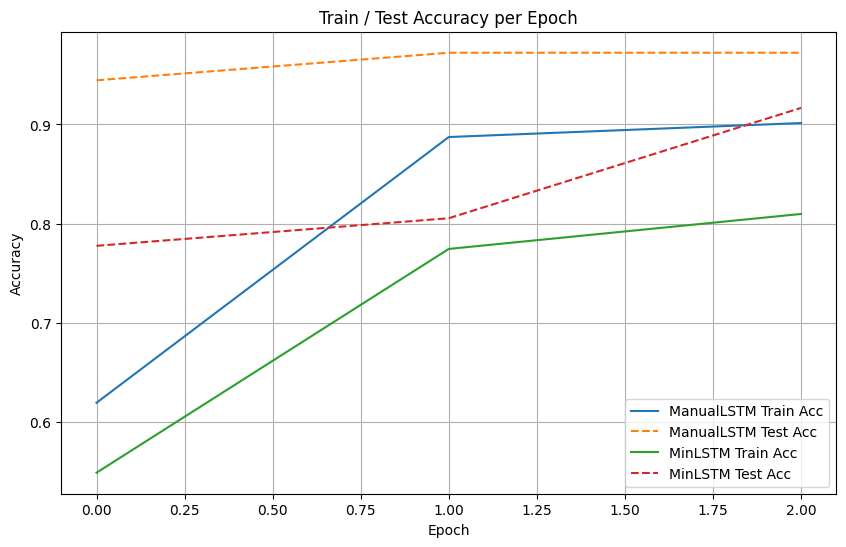

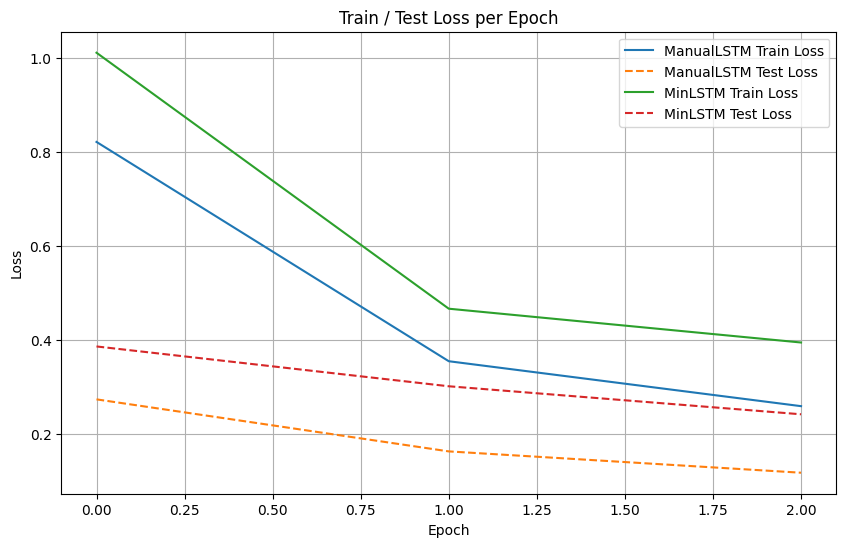

In [43]:
plot_history(histories)

# 6. Triton 기반 병렬화 (minGRU)

## 6.1 minGRU 병렬화 포인트
- 위에서 정리했던 내용 복습

minGRU는 다음과 같은 recurrence 구조를 가짐

$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$

이를 다음과 같이 재구성할 수 있음

$
a_t = 1 - z_t,\quad b_t = z_t \cdot \tilde{h}_t \Rightarrow
h_t = a_t \cdot h_{t-1} + b_t
$

이건 정확히 prefix-scan 가능한 recurrence 구조임

$
h_t = \sum_{k=0}^{t} \left( b_k \cdot \prod_{j=k+1}^{t} a_j \right)
$

이때 병렬 스캔을 log-space로 수햄함으로써 누적 곱을 누적 덧셈으로 치환해 연산함으로써 수치적 안정성을 확보할 수 있으며,  
이는 저정밀도 학습에서도 안정적인 성능 수렴으로 이어질 수 있음

$
\renewcommand{\logsumexp}[1]{\log\left( \sum_{i=1}^{#1} e^{x_i} \right)}
\log h_t = \logsumexp{\log a_t + \log h_{t-1}, \log b_t}
$

다만 위 수식에서 사용되는 logsumexp은 일반적으로 제공되지 않는 수식이므로, 직접 구현해야 하며 다음과 같음

```python
m = maximum(a, b)
logsumexp = m + log(exp(a - m) + exp(b - m))
```

다만 이러한 방법조차 이전의 Mamba에서 살펴본 바와 같이 log(z)가 항상 음수이기에 학습 초기에 모든 값이 작은 음수로 수렴하며
(이로 인해 mamba에서는 음수로 바꾸서 계산하고, 다시 -를 붙여 양수화했었음),  
  
이로 인해 log_b의 gradient가 $\tilde h$로부터 매우 멀어져 제대로 학습되지 않는 문제가 발생했음  
(이를 직접 구현한 triton 모듈로 해결하려 했으나 결국 실패하고, 공식 구현체를 사용했었음)

이러한 문제를 본 논문의 저자들도 공감했기에, log-space 대신 softmax-space 구조로 변경해 scan을 진행  
이에 대한 핵심 아이디어(수식)은 다음과 같음 (from Appendix B.2)

$
h_t = softmax(α_t, β_t) · (h_{t-1}, h̃_t)
$

즉, gate로부터 (1-α, α) 라는 softmax normalized weight를 받아  
h_{t-1}과 h̃_t를 weight sum으로 결합

정리하면, 기존의 minGRU의 recurrence는 다음과 같았음

$
h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t
$

이를 다음과 같이 softmax-space 형태로 표현

```tex
α_t, β_t = softmax([gate_a_t, gate_b_t])
h_t = α_t * h_{t-1} + β_t * h̃_t
```

위 구조는 다음과 같은 장점을 가짐
- gate의 전체 합은 항상 1 -> 안정된 가중합이 가능
- softmax 덕분에 gradient 흐름이 잘 전달됨
- 수치적 안정성 확보

그리고 이렇게 전개한 recurrence는 다음과 같이 별렬 스캔으로 정리됨

```tex
Let:
  a_t = α_t
  b_t = β_t * h̃_t

Then:
  h_t = a_t * h_{t-1} + b_t
```

## 6.2 Softmax-space 기반 Triton 병렬 minGRU

In [114]:
import triton
import triton.language as tl
import math

@triton.jit
def softmaxspace_scan_kernel(
    a_ptr, b_ptr, out_ptr,
    B: tl.constexpr, T: tl.constexpr, D: tl.constexpr,
    stride_bt: tl.constexpr, stride_bd: tl.constexpr,
    BLOCK: tl.constexpr
):
    pid_b = tl.program_id(0)
    pid_d = tl.program_id(1)

    offsets = tl.arange(0, BLOCK)
    mask = offsets < T

    a = tl.load(a_ptr + pid_b * stride_bt + pid_d * stride_bd + offsets, mask=mask, other=1.0)
    b = tl.load(b_ptr + pid_b * stride_bt + pid_d * stride_bd + offsets, mask=mask, other=0.0)

    h = b
    tl.store(out_ptr + pid_b * stride_bt + pid_d * stride_bd + offsets, h, mask=mask)

    for i in tl.static_range(int(math.log2(2048))):
        shift = 1 << i
        src_mask = offsets >= shift
        src_offsets = offsets - shift

        a_lhs = tl.load(a_ptr + pid_b * stride_bt + pid_d * stride_bd + src_offsets, mask=src_mask, other=1.0)
        h_lhs = tl.load(out_ptr + pid_b * stride_bt + pid_d * stride_bd + src_offsets, mask=src_mask, other=0.0)

        h_comb = a_lhs * h_lhs + b[src_mask]
        h = tl.where(src_mask, h_comb, h)

        tl.store(out_ptr + pid_b * stride_bt + pid_d * stride_bd + offsets, h, mask=mask)


In [115]:
def triton_softmax_gru_scan(a, b):
    B, T, D = a.shape
    BLOCK = 2 ** math.ceil(math.log2(T))
    a_pad = torch.ones((B, BLOCK, D), device=a.device)
    b_pad = torch.zeros((B, BLOCK, D), device=b.device)
    a_pad[:, :T] = a
    b_pad[:, :T] = b

    out = torch.empty_like(b_pad)
    grid = (B, D)

    softmaxspace_scan_kernel[grid](
        a_pad, b_pad, out,
        B=B, T=T, D=D,
        stride_bt=BLOCK,
        stride_bd=1,
        BLOCK=BLOCK
    )

    return out[:, :T]


In [ ]:
class SoftmaxMinGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gate_proj = nn.Linear(input_size, 2 * hidden_size)  # α, β
        self.h_proj = nn.Linear(input_size, hidden_size)         # h̃
        self.hidden_size = hidden_size

    def forward(self, x, _):  # h_prev는 병렬 스캔에 의해 계산됨
        gate = self.gate_proj(x)  # [B,T,2H]
        a_raw, b_raw = gate.chunk(2, dim=-1)
        gate_weights = torch.stack([a_raw, b_raw], dim=-1)       # [B,T,H,2]
        gate_weights = torch.softmax(gate_weights, dim=-1)       # α, β 합이 1

        a_t = gate_weights[..., 0]                                # α
        b_t = gate_weights[..., 1]                                # β
        h_tilde = torch.tanh(self.h_proj(x))                      # 안정성 위해 tanh 추가
        b_vec = b_t * h_tilde                                     # [B,T,H]

        # 병렬 prefix scan (softmax-space 구조)
        h = triton_softmax_gru_scan(a_t, b_vec)
        return h


In [117]:
class SoftmaxMinGRUBlock(nn.Module):
    def __init__(self, cell_class, input_size, hidden_size, num_layers=2, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList() if norm else None
        self.dropouts = nn.ModuleList()

        for i in range(num_layers):
            in_dim = input_size if i == 0 else hidden_size
            self.layers.append(cell_class(in_dim, hidden_size))
            if norm:
                self.norms.append(nn.LayerNorm(hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x_ = layer(x, None)
            if self.norms:
                x_ = self.norms[i](x_)
            x_ = self.dropouts[i](x_)
            if self.residual and x_.shape == x.shape:
                x = x + x_
            else:
                x = x_
        return x


In [118]:
class SoftmaxMinGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super().__init__()
        self.rnn = SoftmaxMinGRUBlock(SoftmaxMinGRUCell, input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.rnn(x)
        return self.fc(x[:, -1])

In [120]:
models = {
    # "minGRU(PyTorch)": ModernMinGRUClassifier(1, 32, 3),
    "minGRU(Triton-Softmax)": SoftmaxMinGRUClassifier(1, 32, 3)
}

histories = {}
for name, model in models.items():
    print_model_stats(model, name)
    print(f">>> {name} 학습 시작")
    histories[name] = train_and_eval_with_timer(model, train_loader, test_loader, epochs=50)



minGRU(Triton-Softmax) 구조 요약:
{}


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Linear: 4, Linear: 4]

In [1]:
import torch
import triton
import triton.language as tl

@triton.jit
def min_gru_scan_kernel(
    Z,               # z_t: [B, T, H]
    HT,              # h_tilde: [B, T, H]
    H0,              # h_0:    [B, H]
    OUT,             # output h: [B, T, H]
    T: tl.constexpr, # sequence length
    H: tl.constexpr, # hidden size
    BLOCK: tl.constexpr # block size
):
    b = tl.program_id(0)  # batch index
    h = tl.program_id(1)  # hidden unit index

    # Load initial state
    h_acc = tl.load(H0 + b * H + h)      # h_{t=0}
    # We carry an “attenuation” coefficient too, but since for minGRU a_t+z_t=1,
    # it's redundant to keep separately—h_acc already encodes both.
    for block_start in range(0, T, BLOCK):
        # offsets within the block
        offs = block_start + tl.arange(0, BLOCK)
        mask = offs < T

        # load gates
        z = tl.load(Z   + b * T * H + offs * H + h, mask=mask, other=0.0)
        ht = tl.load(HT + b * T * H + offs * H + h, mask=mask, other=0.0)

        # compute coefficients
        a = 1.0 - z
        bval = z * ht

        # do a local (sequential) scan over this small block
        # local_h accumulates the h within block
        local_h = h_acc
        for i in range(BLOCK):
            m = mask[i]
            ai = a[i]
            bi = bval[i]
            # h_i = ai * h_{i-1} + b_i
            local_h = ai * local_h + bi
            # write out
            tl.store(OUT + b * T * H + (block_start + i) * H + h,
                     local_h, mask=m)
        # after block, h_acc holds h at the end of this block
        # so it’s ready for the next block


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
import torch
import torch.nn as nn

class TritonMinGRUScan(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, h_tilde, h0):
        B, T, H = z.shape
        out = torch.empty_like(z)
        # launch grid: B x H
        grid = (B, H)
        BLOCK = 64  # you can tune this for your GPU
        min_gru_scan_kernel[grid](
            z, h_tilde, h0, out,
            T, H, BLOCK,
            num_warps=4,
        )
        ctx.save_for_backward(z, h_tilde, h0, out)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        # fallback to PyTorch’s sequential for simplicity in backward
        z, h_tilde, h0, out = ctx.saved_tensors
        # recompute with autograd
        with torch.enable_grad():
            z_ = z.detach().requires_grad_()
            ht_ = h_tilde.detach().requires_grad_()
            h0_ = h0.detach().requires_grad_()
            seq = torch.zeros_like(z_)
            h = h0_
            for t in range(z_.shape[1]):
                a = 1 - torch.sigmoid(z_[:, t])
                b = torch.sigmoid(z_[:, t]) * ht_[:, t]
                h = a * h + b
                seq[:, t] = h
        seq.backward(grad_out)
        return z_.grad, ht_.grad, h0_.grad

class MinGRUCellTriton(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size)
        self.h_proj = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        # x: [B, T, D]
        B, T, _ = x.size()
        z = torch.sigmoid(self.z_proj(x))               # [B,T,H]
        ht = self.h_proj(x)                             # [B,T,H]
        h0 = x.new_zeros(B, ht.size(-1))                # init h0
        return TritonMinGRUScan.apply(z, ht, h0)


In [4]:
class ModernMinGRUClassifierTriton(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.cell = MinGRUCellTriton(input_size, hidden_size)
        self.fc   = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_seq = self.cell(x)                # [B, T, H]
        return self.fc(h_seq[:, -1])        # final state

In [1]:
import torch
import torch.nn as nn
import time

# -----------------------------------
# Sequential MinGRU Implementation
# -----------------------------------
class MinGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size)
        self.h_proj = nn.Linear(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x_t, h_prev):
        z_t = torch.sigmoid(self.z_proj(x_t))
        h_tilde = self.h_proj(x_t)
        a_t = 1.0 - z_t
        b_t = z_t * h_tilde
        return a_t * h_prev + b_t

class RNNBlockGRU(nn.Module):
    def __init__(self, cell_class, input_size, hidden_size,
                 num_layers=4, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.num_layers = num_layers
        self.residual = residual
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList() if norm else None
        self.dropouts = nn.ModuleList()
        for i in range(num_layers):
            in_dim = input_size if i == 0 else hidden_size
            self.layers.append(cell_class(in_dim, hidden_size))
            if norm:
                self.norms.append(nn.LayerNorm(hidden_size))
            self.dropouts.append(nn.Dropout(dropout))

    def forward(self, x, h0=None):
        B, T, _ = x.shape
        x_in = x
        for i, layer in enumerate(self.layers):
            h = h0[i] if h0 is not None else x.new_zeros(B, layer.hidden_size)
            outputs = []
            for t in range(T):
                h = layer(x_in[:, t], h)
                outputs.append(h.unsqueeze(1))
            x_out = torch.cat(outputs, dim=1)
            if self.norms:
                x_out = self.norms[i](x_out)
            x_out = self.dropouts[i](x_out)
            if self.residual and x_out.shape == x_in.shape:
                x_out = x_in + x_out
            x_in = x_out
        return x_in

class ModernMinGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = RNNBlockGRU(MinGRUCell, input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        seq = self.rnn(x)
        return self.fc(seq[:, -1])

# -----------------------------------
# Triton-based Softmax-space SCAN (simplified sequential scan per thread)
# -----------------------------------
import triton
import triton.language as tl

@triton.jit
def min_gru_scan_kernel(
    Z, HT, H0, OUT,
    T: tl.constexpr, H: tl.constexpr
):
    # grid: (B, H)
    b = tl.program_id(0)
    h = tl.program_id(1)
    z_base = Z + b * T * H + h
    ht_base = HT + b * T * H + h
    out_base = OUT + b * T * H + h

    # initial state
    h_acc = tl.load(H0 + b * H + h)
    for t in range(T):
        z_t = tl.load(z_base + t * H)
        ht_t = tl.load(ht_base + t * H)
        a = 1.0 - z_t
        bval = z_t * ht_t
        h_acc = a * h_acc + bval
        tl.store(out_base + t * H, h_acc)

class TritonMinGRUScan(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, h_tilde, h0):
        z = z.contiguous(); h_tilde = h_tilde.contiguous()
        B, T, H = z.shape
        out = torch.empty_like(z)
        grid = (B, H)
        # launch kernel
        min_gru_scan_kernel[grid](
            z, h_tilde, h0, out,
            T, H,
            num_warps=4
        )
        ctx.save_for_backward(z, h_tilde, h0)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        z, ht, h0 = ctx.saved_tensors
        B, T, H = z.shape
        h = h0
        seq = torch.zeros_like(z)
        for t in range(T):
            a = 1 - z[:, t]
            b = z[:, t] * ht[:, t]
            h = a * h + b
            seq[:, t] = h
        seq.backward(grad_out)
        return z.grad, ht.grad, None

class MinGRUCellTriton(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size)
        self.h_proj = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        z = torch.sigmoid(self.z_proj(x))
        ht = self.h_proj(x)
        h0 = x.new_zeros(x.shape[0], ht.shape[-1])
        return TritonMinGRUScan.apply(z, ht, h0)

class ModernMinGRUClassifierTriton(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.cell = MinGRUCellTriton(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        seq = self.cell(x)
        return self.fc(seq[:, -1])

# -----------------------------------
# Benchmarking Utility
# -----------------------------------
def benchmark(model, x, trials=100):
    model = model.cuda()
    x = x.cuda()
    with torch.no_grad():
        for _ in range(10): model(x)
    torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        for _ in range(trials): model(x)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    print(f"{model.__class__.__name__}: {elapsed / trials * 1000:.3f} ms per forward")

if __name__ == '__main__':
    B, T, D, H = 32, 128, 256, 256
    num_classes = 10
    x = torch.randn(B, T, D)
    model_seq = ModernMinGRUClassifier(D, H, num_classes)
    model_triton = ModernMinGRUClassifierTriton(D, H, num_classes)
    print("Benchmarking models on random data:")
    benchmark(model_seq, x)
    benchmark(model_triton, x)


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Benchmarking models on random data:
ModernMinGRUClassifier: 62.817 ms per forward
ModernMinGRUClassifierTriton: 0.291 ms per forward


In [4]:
import torch; import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import triton; import triton.language as tl

In [5]:
@triton.jit
def scan_kernel(Z, HT, H0, OUT, T: tl.constexpr, H: tl.constexpr):
    b, h = tl.program_id(0), tl.program_id(1)
    base_z  = Z + b * T * H + h
    base_ht = HT + b * T * H + h
    base_o  = OUT + b * T * H + h
    acc = tl.load(H0 + b * H + h)
    for t in range(T):
        z_t = tl.load(base_z + t * H)
        ht_t = tl.load(base_ht + t * H)
        acc = (1.0 - z_t) * acc + z_t * ht_t
        tl.store(base_o + t * H, acc)

class TritonMinGRUScan(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, h_tilde, h0):
        z = z.contiguous()
        h_tilde = h_tilde.contiguous()
        B, T, H = z.shape
        out = torch.empty_like(z)
        grid = (B, H)
        scan_kernel[grid](z, h_tilde, h0, out, T, H, num_warps=4)
        ctx.save_for_backward(z, h_tilde, h0)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        z, h_tilde, h0 = ctx.saved_tensors
        B, T, H = z.shape
        # forward replay to accumulate h and a
        h_list, a_list = [], []
        h_prev = h0
        for t in range(T):
            zt = z[:, t, :]
            htl = h_tilde[:, t, :]
            a_t = 1.0 - zt
            h = a_t * h_prev + zt * htl
            h_list.append(h)
            a_list.append(a_t)
            h_prev = h
        # backward scan for gradients
        grad_z = torch.zeros_like(z)
        grad_htilde = torch.zeros_like(h_tilde)
        delta = torch.zeros_like(h0)
        for t in range(T - 1, -1, -1):
            a_next = a_list[t + 1] if t < T - 1 else 0.0
            delta = grad_out[:, t, :] + a_next * delta
            h_prev = h0 if t == 0 else h_list[t - 1]
            grad_z[:, t, :] = delta * (h_tilde[:, t, :] - h_prev)
            grad_htilde[:, t, :] = delta * z[:, t, :]
        return grad_z, grad_htilde, None

@triton.jit
def scan_kernel(Z, HT, H0, OUT, T: tl.constexpr, H: tl.constexpr):
    b, h = tl.program_id(0), tl.program_id(1)
    base_z  = Z + b * T * H + h
    base_ht = HT + b * T * H + h
    base_o  = OUT + b * T * H + h
    acc = tl.load(H0 + b * H + h)
    for t in range(T):
        z_t = tl.load(base_z + t * H)
        ht_t = tl.load(base_ht + t * H)
        acc = (1.0 - z_t) * acc + z_t * ht_t
        tl.store(base_o + t * H, acc)

class TritonMinGRUScan(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z, h_tilde, h0):
        # ensure contiguous inputs
        z = z.contiguous()
        h_tilde = h_tilde.contiguous()
        B, T, H = z.shape
        out = torch.empty_like(z)
        grid = (B, H)
        # launch Triton scan kernel
        scan_kernel[grid](z, h_tilde, h0, out, T, H, num_warps=4)
        ctx.save_for_backward(z, h_tilde, h0)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        z, h_tilde, h0 = ctx.saved_tensors
        # recompute forward with PyTorch ops for autograd
        z_ = z.detach().requires_grad_()
        ht_ = h_tilde.detach().requires_grad_()
        h = h0.detach()
        out_list = []
        for t in range(z_.shape[1]):
            a = 1 - z_[:, t]
            b = z_[:, t] * ht_[:, t]
            h = a * h + b
            out_list.append(h)
        seq = torch.stack(out_list, dim=1)
        # compute gradients w.r.t. z and h_tilde
        grad_z, grad_ht = torch.autograd.grad(seq, (z_, ht_), grad_out)
        return grad_z, grad_ht, None

class RNNBlockGRUTriton(nn.Module):
    def __init__(self, D, H, L=2, dropout=0.1, norm=True, residual=True):
        super().__init__()
        self.cells = nn.ModuleList([MinGRUCellTriton(D if i==0 else H, H) for i in range(L)])
        self.norms = nn.ModuleList([nn.LayerNorm(H) for _ in range(L)]) if norm else None
        self.drop  = nn.ModuleList([nn.Dropout(dropout) for _ in range(L)])
        self.residual = residual

    def forward(self, x):
        out = x
        for i, cell in enumerate(self.cells):
            z = torch.sigmoid(cell.z_proj(out))
            ht = cell.h_proj(out)
            h0 = out.new_zeros(out.size(0), ht.size(-1))
            seq = TritonMinGRUScan.apply(z, ht, h0)
            if self.norms: seq = self.norms[i](seq)
            seq = self.drop[i](seq)
            if self.residual and seq.shape == out.shape:
                seq = out + seq
            out = seq
        return out

class ModernMinGRUTriton(nn.Module):
    def __init__(self, D, H, C):
        super().__init__()
        self.rnn = RNNBlockGRUTriton(D, H, L=2)
        self.fc  = nn.Linear(H, C)

    def forward(self, x):
        return self.fc(self.rnn(x)[:, -1])

In [6]:
# 4.1. 데이터 준비 (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST('.', train=True, transform=transform, download=True)
test_ds  = datasets.MNIST('.', train=False,transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

# 4.2. 학습 루프
def train(model, opt):
    model.train()
    for x,y in train_loader:
        # [B,1,28,28]→[B,28,28]
        x = x.squeeze(1).permute(0,2,1)
        opt.zero_grad(); out=model(x.cuda()); loss=nn.CrossEntropyLoss()(out, y.cuda()); loss.backward(); opt.step()

def evaluate(model):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y in test_loader:
            x = x.squeeze(1).permute(0,2,1)
            pred = model(x.cuda()).argmax(dim=-1)
            correct += (pred==y.cuda()).sum().item(); total += y.size(0)
    return correct/total

# 4.3. 실행 및 비교
seq = ModernMinGRUSeq(28,128,10).cuda()
tri = ModernMinGRUTriton(28,128,10).cuda()
opt_s = torch.optim.Adam(seq.parameters(), lr=1e-3)
opt_t = torch.optim.Adam(tri.parameters(), lr=1e-3)

for epoch in range(5):
    train(seq,opt_s); train(tri,opt_t)
    acc_s, acc_t = evaluate(seq), evaluate(tri)
    print(f"Epoch {epoch}: Seq Acc={acc_s:.4f}, Triton Acc={acc_t:.4f}")

NameError: name 'ModernMinGRUSeq' is not defined